This Jupyter notebook contains the code used to produce the figures in the paper "Characterizing the Multisectoral Impacts of Future Global Hydrologic Variability" by Birnbaum et al. currently under review.

In [ ]:
conda install -c conda-forge rtree=0.9.3

# Import Statements

Begin by importing the following relavent Python libraries/packages

In [1]:
# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm

#load in self-defined functions in HydroVar_functions.py
from HydroVar_functions import *

import warnings
warnings.filterwarnings('ignore')

OSError: could not find or load spatialindex_c-64.dll

And also set the color palette used for most of the figures

In [2]:
# set color palette
cpal = sns.color_palette('Paired',12)

# Load in and clean up historical data

In [5]:
# set path to data
fpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/'
histpath = 'isimip3a_watergap2-2e_gswp3-w5e5_runoff/'

# load in "observed" data - watergap2 model that xanthos is calibrated to
# watergap2 columns are basin, year, month, and runoff value.
obs_data = pd.read_csv(fpath+histpath+'watergap2-2e_gswp3-w5e5_obsclim_histsoc_nowatermgt_qtot_basin_km3-per-mth_1901_2019.csv')

# load in xanthos historical data used for calibration
# xanthos columns are yearmonth, rows are basins - from 1901 to 2010
det_data = pd.read_csv(fpath+histpath+'Basin_runoff_km3permonth_pm_abcd_mrtm_watergap2-2e_gswp3-w5e5_1901_2019.csv')

# load in map of global GCAM basins
gcam_basins = gpd.read_file(fpath+'gcam_basins/gcam_basins.shp')
gcam_basins = gcam_basins.filter(['sbRgnAl','geometry','area','subRegn'])
gcam_basins = gcam_basins.rename(columns={'sbRgnAl':'basin_id'})
gcam_basins['basin_id'] = gcam_basins['basin_id'].astype(int)

# create dictionary mapping basin name to basin id
basin_dict = dict(zip(det_data.name,det_data.id))

# convert deterministic model data to same format as observed data
det_data2 = det_data.T # transpose data frame
det_data2.columns = det_data2.iloc[1] # set column names to basin names
det_data2 = det_data2.iloc[2:] # remove first two rows of dataframe (column names and associated ID, will add back later)

det_data3 = det_data2.unstack() # reformat so year,month and basin_name are columns
det_data3 = det_data3.reset_index()
det_data3 = det_data3.rename(columns={'name':'basin_name','level_1':'year_month',0:'q'}) # rename columns
det_data3['basin_id'] = det_data3['basin_name'].map(basin_dict) # create column for basin ID
det_data3['year'] = det_data3['year_month'].str[0:4].astype(int) # create column for year
det_data3['month'] = det_data3['year_month'].str[4:].astype(int) # create column for month

# merge deterministic model and observed dataframes
obs_data = obs_data.rename(columns={'basin':'basin_id'}) # rename column for basin id in observed dataframe
data = obs_data.merge(det_data3,on=['basin_id','year','month'],suffixes=['_obs','_det']) # merge dataframes
data = data.filter(['basin_name','basin_id','year','month','q_obs','q_det'])

# Convert Runoff from Monthly to Annual
data['q_det'] = data['q_det'].astype(float)
data_annual = data.groupby(['basin_id','basin_name','year'])['q_obs','q_det'].sum() #annual runoff by basin
data_annual = data_annual.reset_index()

# load in recalibrated Upper Colorado Basin
up_col = np.load('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/gutacalib_220.npy')
yrs = np.linspace(1901,2019,119).astype(int)
up_col_runoff = pd.DataFrame()
up_col_runoff['value'] = up_col
up_col_runoff['year'] = np.repeat(yrs,12)
up_col_runoff = up_col_runoff.groupby(['year'])['value'].sum().reset_index()

#replace the upper colorado with the recalibrated data
data_annual.loc[data_annual.basin_id==220,'q_det'] = up_col_runoff.value.to_numpy()

# Load in and clean up deterministic projection of future runoff

In [6]:
# path to data (GFDL SSP3 RCP7.0)
futpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/isimip3b_cmip6_xanthos/'
scen = 'cmip6_gfdl-esm4_r1i1p1f1_ssp370/'

#read in data
fut_data = pd.read_csv(futpath+scen+'Basin_runoff_km3permonth_gfdl-esm4_r1i1p1f1_ssp370_1850_2100.csv')

#create dictionary mapping basin name to basin id
basin_dict = dict(zip(fut_data.name,fut_data.id))

#convert futulated data to same format as observed data
fut_data2 = fut_data.T #transpose data frame
fut_data2.columns = fut_data2.iloc[1] #set column names to basin names
fut_data2 = fut_data2.iloc[2:] #remove first two rows of dataframe (column names and associated ID, will add back later)

fut_data3 = fut_data2.unstack() #reformat so year,month and basin_name are columns
fut_data3 = fut_data3.reset_index()
fut_data3 = fut_data3.rename(columns={'name':'basin_name','level_1':'year_month',0:'q_fut'}) # rename columns
fut_data3['basin_id'] = fut_data3['basin_name'].map(basin_dict) # create column for basin ID
fut_data3['year'] = fut_data3['year_month'].str[0:4].astype(int) # create column for year
fut_data3['month'] = fut_data3['year_month'].str[4:].astype(int) # create column for month

fut_annual = fut_data3.groupby(['basin_id','basin_name','year'])['q_fut'].sum().reset_index() # annual runoff by basin
fut_annual = fut_annual[fut_annual.year>2019] # limit future to starting in 2020

# make sure data_annual and fut_annual are in proper order
data_annual = data_annual.sort_values(by=['basin_id','year'])
fut_annual = fut_annual.sort_values(by=['basin_id','year'])

# rename Missouri for both historical and future dataframes
data_annual.loc[data_annual.basin_name=='Missouri River Basin','basin_name'] = 'Missouri'
fut_annual.loc[fut_annual.basin_name=='Missouri River Basin','basin_name'] = 'Missouri'

#save data_annual and fut_annual
data_annual.set_index('basin_id').to_csv('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_1/hist_annual.csv',encoding='utf-8',header=True)
fut_annual.set_index('basin_id').to_csv('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_1/fut_annual_gfdl_ssp370.csv',encoding='utf-8',header=True)

# Run Stochastic Model for 1000 simulations

In [7]:
df = data_annual # historical data
df_fut = fut_annual # future data
m = 1000 # number of stochastic realizations to generate

Q = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations

# make sure there are no negative runoff values - set minimum to be zero for both historical and future
Q[Q<0] = 0

basin_nms = data_annual.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(data_annual['year'].unique()[:]) # get # of years

# get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

# get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(fut_annual.year.unique())
fut_annual['q_fut'] = fut_annual['q_fut'].astype(float)
q_fut = np.reshape(fut_annual.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')


## FIGURE 1: plot map, % error plot, and flow duration curves for select basins

In [8]:
#calculate deterministic model NSE
nse_det = np.zeros([nbasins,2]) # create empty storage array for NSE

for i in range(nbasins): # loop through basins
    df_basin = data_annual[data_annual.basin_name==basin_nms[i]] 
    boi_obs = df_basin.q_obs.to_numpy() # observed runoff
    boi_det = df_basin.q_det.to_numpy() # deterministic model runoff
    nse_det[i,0] = df_basin['basin_id'].iloc[0] # first column is basin id
    nse_det[i,1] = calc_NSE(boi_obs,boi_det) #second column is NSE

nse_det = pd.DataFrame(nse_det,columns=['basin_id','nse_det']) #create dataframe
nse_det['basin_id'] = nse_det['basin_id'].astype(int) # make basin id integer type
nse_det = gcam_basins.merge(nse_det,on=['basin_id']) # merge with geopandas gcam_basins for plotting

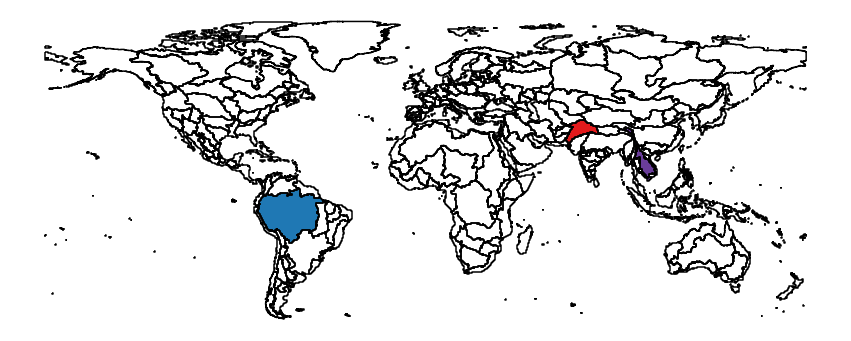

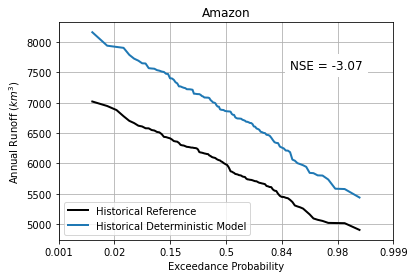

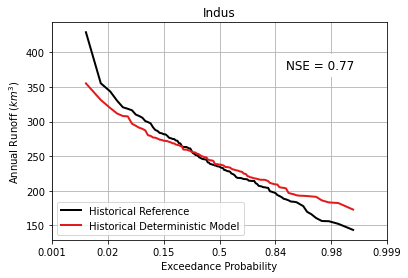

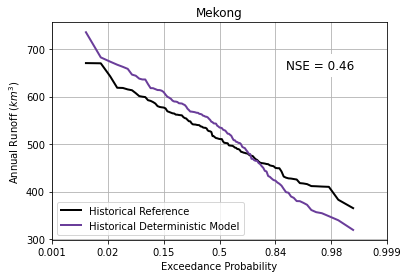

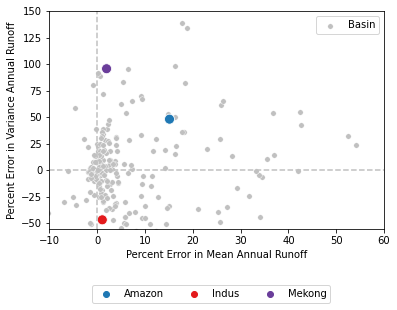

In [9]:
key_basins = ['Amazon','Indus','Mekong'] # select basins to highlight
 
df_key = data_annual[data_annual.basin_name.isin(key_basins)] # create dataframe of these key basins
key_ids = df_key.basin_id.unique() #get basin ids for these key basins

clist = [cpal[1],cpal[5],cpal[9]] # set colors for plotting

# plot map highlighting key basins
fig,ax = plt.subplots(1,1,figsize=(15,10))
gcam_key_basins = gcam_basins[gcam_basins.basin_id.isin(key_ids)]
gcam_key_basins = gcam_key_basins.sort_values(by='subRegn',ascending=True)
gcam_key_basins['c'] = clist
gcam_basins.boundary.plot(ax=ax,color='k')
gcam_key_basins.plot(ax=ax,color=gcam_key_basins['c'])
ax.set_axis_off()
plt.show()

# plot flow duration curves for deterministic/observed:
for i in range(len(key_basins)): # loop through key basins
    fig,ax = plt.subplots(1,1)
    df_basin = data_annual[data_annual.basin_name==key_basins[i]]
    df_basin_fut = fut_annual[fut_annual.basin_name==key_basins[i]]
    bsid = df_basin.basin_id.iloc[0] - 1
    plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],clist[i],'hist_det',ax) #plot
    # get associated NSE for that basin
    key_id = df_basin.basin_id.iloc[0]
    key_nse = nse_det[nse_det.basin_id==key_id]['nse_det'].iloc[0]
    ax.text(0.8,0.8,'NSE = '+str(round(key_nse,2)),
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5},
            ha='center',va='center',transform=ax.transAxes,fontsize=12) # add NSE to plot
    ax.legend(loc='lower left')
    plt.show()

#calculate %error of mean and variance for all basins
df_err = data_annual.copy() #copy dataframe 
df_mean = df_err.groupby(['basin_name','basin_id'])['q_obs','q_det'].mean().reset_index() # get mean
df_std = df_err.groupby(['basin_name','basin_id'])['q_obs','q_det'].std().reset_index() # get standard deviation
df_err = df_mean.merge(df_std,on=['basin_name','basin_id'],suffixes=['_mean','_std']) # merge dataframes
df_err['q_obs_cv'] = df_err['q_obs_std']/df_err['q_obs_mean'] # calculate coefficient of variantion of reference
df_err['q_det_cv'] = df_err['q_det_std']/df_err['q_det_mean'] # calculate coefficient of variation of deterministic
df_err['q_obs_var'] = df_err['q_obs_std']**2 # calculate variance of reference
df_err['q_det_var'] = df_err['q_det_std']**2 # calculate variance of determinsitic 
df_err['perr_mean'] = 100*((df_err.q_det_mean - df_err.q_obs_mean)/df_err.q_obs_mean) # % error of mean
df_err['perr_cv'] = 100*((df_err.q_det_cv - df_err.q_obs_cv)/df_err.q_obs_cv) # % error of CV
df_err['perr_var'] = 100*((df_err.q_det_var - df_err.q_obs_var)/df_err.q_obs_var) # % error of variance
df_err_key = df_err[df_err.basin_name.isin(key_basins)] # now isolate just key basins

fig,ax = plt.subplots(1,1) # plot
plt.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
plt.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(data=df_err,x='perr_mean',y='perr_var',color='silver',s=30,label='Basin') # plot all basins
ax.legend(title='')
sns.scatterplot(data=df_err_key,x='perr_mean',y='perr_var',hue='basin_name',palette=clist,
               hue_order=['Amazon','Indus','Mekong'],s=100,legend=True) # plot key basins
plt.xlabel('Percent Error in Mean Annual Runoff'); plt.ylabel('Percent Error in Variance Annual Runoff')
h, l = ax.get_legend_handles_labels()
plt.legend(h[:1],l[:1],title='')
fig.legend(h[1:],l[1:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.15],ncol=3)
plt.xlim([-10,60])
plt.ylim(-55,150)
plt.show()

In [10]:
display(df_err_key)

,basin_name,basin_id,q_obs_mean,q_det_mean,q_obs_std,q_det_std,q_obs_cv,q_det_cv,q_obs_var,q_det_var,perr_mean,perr_cv,perr_var
8,Amazon,168,5947.335918,6846.810495,459.471403,559.283047,0.077257,0.081685,211113.969893,312797.527149,15.123991,5.732215,48.165243
88,Indus,89,238.747099,241.313829,45.774848,33.415865,0.191729,0.138475,2095.336698,1116.620030,1.075083,-27.775975,-46.709279
118,Mekong,125,512.684832,522.772270,61.730281,86.363034,0.120406,0.165202,3810.627566,7458.573681,1.967571,37.204250,95.730849


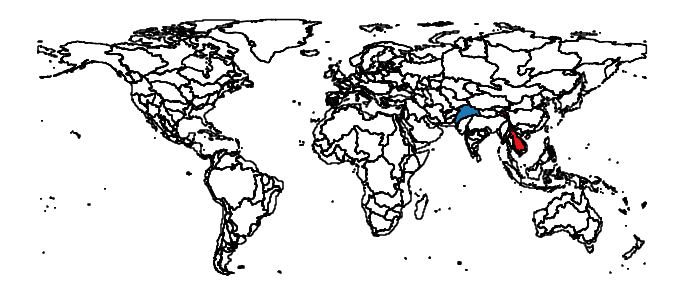

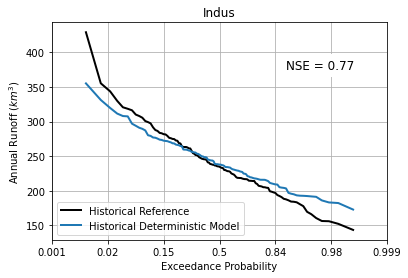

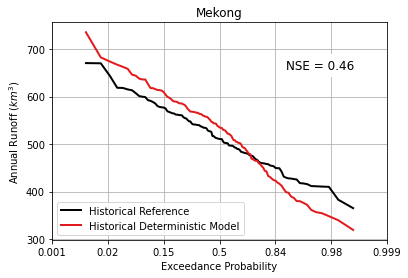

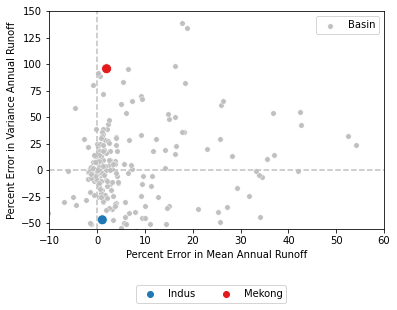

In [11]:
key_basins = ['Indus','Mekong'] # select basins to highlight
 
df_key = data_annual[data_annual.basin_name.isin(key_basins)] # create dataframe of these key basins
key_ids = df_key.basin_id.unique() #get basin ids for these key basins

clist = [cpal[1],cpal[5]] # set colors for plotting

# plot map highlighting key basins
fig,ax = plt.subplots(1,1,figsize=(12,10))
gcam_key_basins = gcam_basins[gcam_basins.basin_id.isin(key_ids)]
gcam_key_basins = gcam_key_basins.sort_values(by='subRegn',ascending=True)
gcam_key_basins['c'] = clist
gcam_basins.boundary.plot(ax=ax,color='k')
gcam_key_basins.plot(ax=ax,color=gcam_key_basins['c'])
ax.set_axis_off()
plt.show()

# plot flow duration curves for deterministic/observed:
for i in range(len(key_basins)): # loop through key basins
    fig,ax = plt.subplots(1,1)
    df_basin = data_annual[data_annual.basin_name==key_basins[i]]
    df_basin_fut = fut_annual[fut_annual.basin_name==key_basins[i]]
    bsid = df_basin.basin_id.iloc[0] - 1
    plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],clist[i],'hist_det',ax) #plot
    # get associated NSE for that basin
    key_id = df_basin.basin_id.iloc[0]
    key_nse = nse_det[nse_det.basin_id==key_id]['nse_det'].iloc[0]
    ax.text(0.8,0.8,'NSE = '+str(round(key_nse,2)),
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5},
            ha='center',va='center',transform=ax.transAxes,fontsize=12) # add NSE to plot
    ax.legend(loc='lower left')
    plt.show()

#calculate %error of mean and variance for all basins
df_err = data_annual.copy() #copy dataframe 
df_mean = df_err.groupby(['basin_name','basin_id'])['q_obs','q_det'].mean().reset_index() # get mean
df_std = df_err.groupby(['basin_name','basin_id'])['q_obs','q_det'].std().reset_index() # get standard deviation
df_err = df_mean.merge(df_std,on=['basin_name','basin_id'],suffixes=['_mean','_std']) # merge dataframes
df_err['q_obs_cv'] = df_err['q_obs_std']/df_err['q_obs_mean'] # calculate coefficient of variantion of reference
df_err['q_det_cv'] = df_err['q_det_std']/df_err['q_det_mean'] # calculate coefficient of variation of deterministic
df_err['q_obs_var'] = df_err['q_obs_std']**2 # calculate variance of reference
df_err['q_det_var'] = df_err['q_det_std']**2 # calculate variance of determinsitic 
df_err['perr_mean'] = 100*((df_err.q_det_mean - df_err.q_obs_mean)/df_err.q_obs_mean) # % error of mean
df_err['perr_cv'] = 100*((df_err.q_det_cv - df_err.q_obs_cv)/df_err.q_obs_cv) # % error of CV
df_err['perr_var'] = 100*((df_err.q_det_var - df_err.q_obs_var)/df_err.q_obs_var) # % error of variance
df_err_key = df_err[df_err.basin_name.isin(key_basins)] # now isolate just key basins

fig,ax = plt.subplots(1,1) # plot
plt.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
plt.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(data=df_err,x='perr_mean',y='perr_var',color='silver',s=30,label='Basin') # plot all basins
ax.legend(title='')
sns.scatterplot(data=df_err_key,x='perr_mean',y='perr_var',hue='basin_name',palette=clist,
               hue_order=['Indus','Mekong'],s=100,legend=True) # plot key basins
plt.xlabel('Percent Error in Mean Annual Runoff'); plt.ylabel('Percent Error in Variance Annual Runoff')
h, l = ax.get_legend_handles_labels()
plt.legend(h[:1],l[:1],title='')
fig.legend(h[1:],l[1:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.15],ncol=3)
plt.xlim([-10,60])
plt.ylim(-55,150)
plt.show()

# Assess Model Performance

## Look at model performance (bias, variance, correlation) for each basin across both deterministic model and stochastic ensemble

In [12]:
#Lamontagne, Barber, and Vogel NSE paper

m = 1000 #size of stochastic ensemble

#empty storage arrays
rho_det = np.zeros(nbasins)
delta_det = np.zeros(nbasins)
alpha_det = np.zeros(nbasins)
rho_stoch_median = np.zeros(nbasins)
delta_stoch_median = np.zeros(nbasins)
alpha_stoch_median = np.zeros(nbasins)

#for each basin
for j in range(nbasins):
    bsid = j+1
    df_basin = data_annual[data_annual.basin_id==bsid]
    bsnm = df_basin.basin_name.iloc[0]
    df_basin_stoch = Q_hist[:,bsid-1,:]

    #calculate bias, variance, correlation using mean, standard
    #deviation, rho, delta, alpha
    
    #observed
    mu_obs = np.mean(df_basin.q_obs)
    sig_obs = np.std(df_basin.q_obs)

    #deterministic
    mu_det = np.mean(df_basin.q_det)
    sig_det = np.std(df_basin.q_det)
    rho_det[j] = np.corrcoef(df_basin.q_obs,df_basin.q_det)[0,1]
    delta_det[j] = (mu_obs - mu_det)/mu_obs
    alpha_det[j] = sig_det/sig_obs

    #stochastic
    mu_stoch = np.mean(df_basin_stoch,axis=0)
    sig_stoch = np.std(df_basin_stoch,axis=0)
    rho_stoch = np.zeros(m)
    for i in range(m):
        rho_stoch[i] = np.corrcoef(df_basin.q_obs,df_basin_stoch[:,i])[0,1]
    delta_stoch= (mu_obs - mu_stoch)/mu_obs
    alpha_stoch = sig_stoch/sig_obs
    #median of stochastic
    rho_stoch_median[j] = np.median(rho_stoch)
    delta_stoch_median[j] = np.median(delta_stoch)
    alpha_stoch_median[j] = np.median(alpha_stoch)
    

In [13]:
basin_nms = df['basin_name'].unique() #get list of basin names
basin_ids = df['basin_id'].unique()

In [14]:
#create data frame of mdoel statistics (rho, delta, alpha)
model_stats = pd.DataFrame()
model_stats['basin_nm'] = basin_nms
model_stats['basin_id'] = basin_ids
model_stats['rho_det'] = rho_det
model_stats['delta_det'] = delta_det
model_stats['alpha_det'] = alpha_det
model_stats['rho_stoch_median'] = rho_stoch_median
model_stats['delta_stoch_median'] = delta_stoch_median
model_stats['alpha_stoch_median'] = alpha_stoch_median
model_stats = gcam_basins.merge(model_stats,on=['basin_id'])

In [15]:
dmin = np.min([model_stats.delta_det.min(),model_stats.delta_stoch_median.min()])
dmax = np.max([model_stats.delta_det.max(),model_stats.delta_stoch_median.max()])
dval = np.max([np.abs(dmin),np.abs(dmax)])

amin = np.min([model_stats.alpha_det.min(),model_stats.alpha_stoch_median.min()])
amax = np.max([model_stats.alpha_det.max(),model_stats.alpha_stoch_median.max()])

rmin = np.min([model_stats.rho_det.min(),model_stats.rho_stoch_median.min()])
rmax = np.max([model_stats.rho_det.max(),model_stats.rho_stoch_median.max()])
rmin = 0
rmax = 1

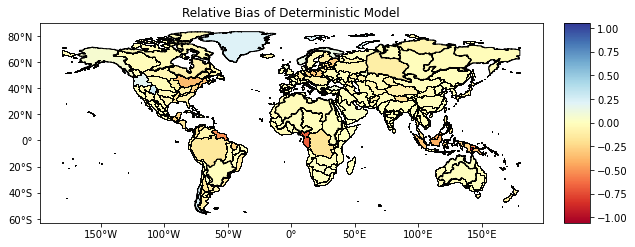

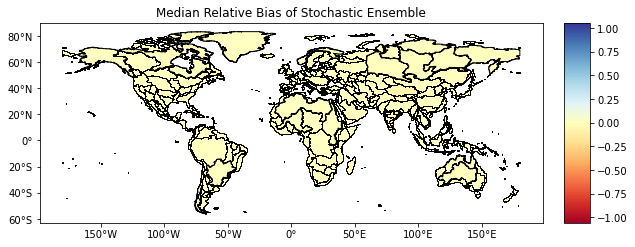

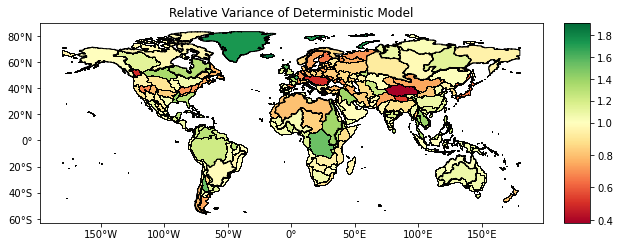

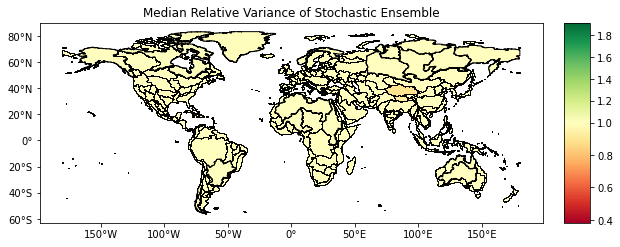

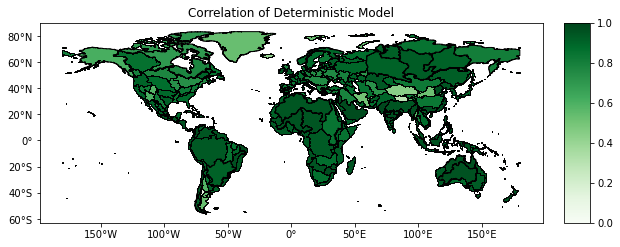

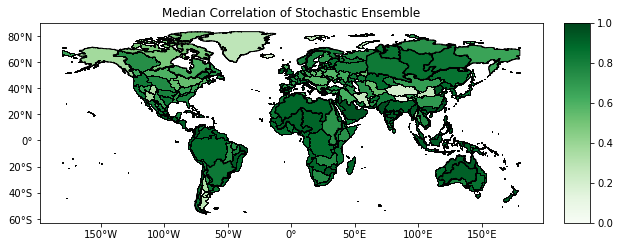

In [16]:
col_names = ['delta_det','delta_stoch_median',
            'alpha_det','alpha_stoch_median',
            'rho_det','rho_stoch_median']
vmins = [-dval,-dval,amin,amin,rmin,rmin]
vmaxs = [dval,dval,amax,amax,rmax,rmax]
vcenters = [0,0,1,1,0.5,0.5]
plt_titles = ['Relative Bias of Deterministic Model',
             'Median Relative Bias of Stochastic Ensemble',
             'Relative Variance of Deterministic Model',
             'Median Relative Variance of Stochastic Ensemble',
             'Correlation of Deterministic Model',
             'Median Correlation of Stochastic Ensemble']
cmaps = ['RdYlBu','RdYlBu','RdYlGn','RdYlGn','Greens','Greens']

for j in range(len(col_names)):
    col_name = col_names[j]
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    model_stats.plot(ax=ax,cax=cax,column=col_name,legend=True,cmap=cmaps[j],
                    norm = mcolors.TwoSlopeNorm(vmin=vmins[j],vmax=vmaxs[j],vcenter=vcenters[j]),
                     edgecolor='k')
    axlbl = fig.axes[0]; ticksizes = axlbl.figure; cb_ax = ticksizes.axes[0]; cb_ax.tick_params(labelsize=14)
    cb_ax.set_xticks([-150,-100,-50,0,50,100,150]); cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
    cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
    cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
    cb_ax = ticksizes.axes[0]; cb_ax.tick_params(labelsize=10);
    ax.set_title(plt_titles[j])
    plt.show()

In [17]:
#convert pearson correlation coefficient to fisher z transform 
model_stats['rho_det_fisherz'] = 0.5*(np.log(1+model_stats['rho_det']) - np.log(1-model_stats['rho_det']))
model_stats['rho_stoch_median_fisherz'] = 0.5*(np.log(1+model_stats['rho_stoch_median']) - np.log(1-model_stats['rho_stoch_median']))

In [18]:
print(np.min(model_stats.rho_det))
print(np.min(model_stats.rho_stoch_median))

0.11844082209924237
0.009922845457044915


## FIGURE X: historical SWM model performance

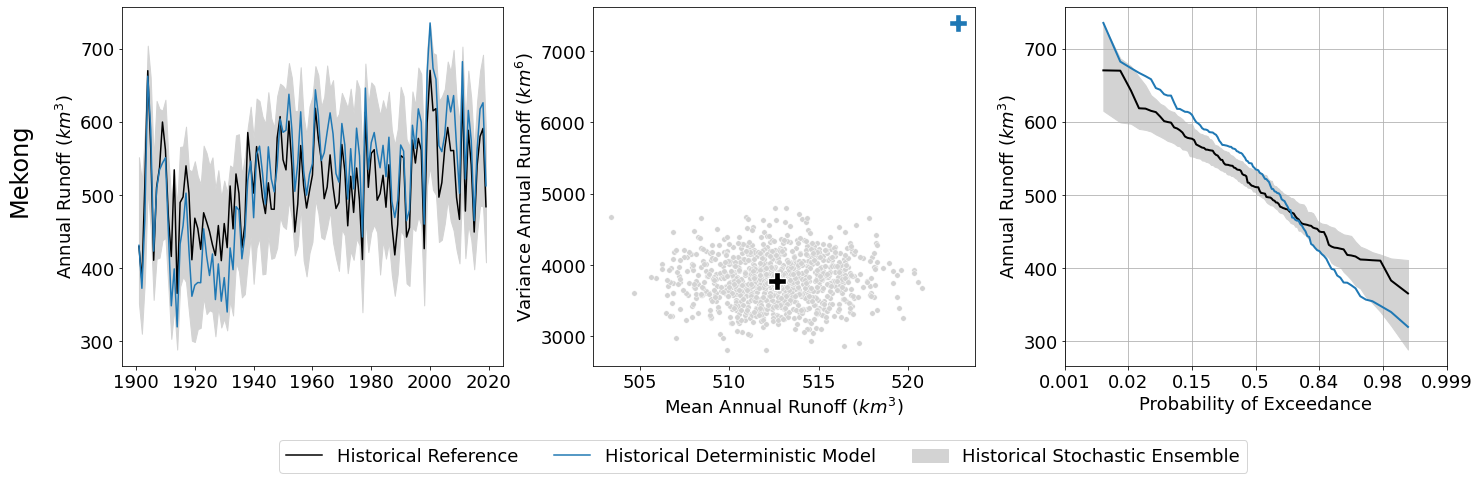

In [19]:
# results plots for a specific basin
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6),
                                 gridspec_kw={'width_ratios': [1, 1,1]})

bs_name = 'Mekong'
bsid = data_annual[data_annual.basin_name==bs_name]['basin_id'].iloc[0] - 1
df_basin = data_annual[data_annual.basin_name==bs_name] 
df_basin_fut = fut_annual[fut_annual.basin_name==bs_name]

boi_obs = q_ref[:,bsid] #observed
boi_det = q_det[:,bsid] #deterministic
boi_stoch = Q_hist[:,bsid,:] #stochastic
boi_fdet = q_fut[:,bsid]#future
boi_fstoch = Q_fut[:,bsid,:]#future stochastic

# subplot 1: time series
years = data_annual.year.unique()[:]
fyears = fut_annual.year.unique()[:]
sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color='lightgray')
ax1.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)

# subplot 2: plot scatterplots of mean vs variance in annual runoff
sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                label='Historical Stochastic Ensemble',color='lightgray',legend=False)
sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False
               ,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',
                color=cpal[1],legend=False,marker='P')
ax2.set_xlabel('Mean Annual Runoff ($km^3$)',fontsize=18)
ax2.set_ylabel('Variance Annual Runoff ($km^6$)',fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

# subplot 3: probability of exceedance for future
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],'hist_stoch',ax3)
ax3.set_xlabel('Probability of Exceedance',fontsize=18)
ax3.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)
ax3.set_title('')
ax3.tick_params(axis='both', which='major', labelsize=18)

fig.legend(['Historical Reference','Historical Deterministic Model','Historical Stochastic Ensemble'],
           ncol=3,loc='lower center',fontsize=18,
          bbox_to_anchor=(0.5, -0.125))

fig.text(-0.025,0.5,bs_name,fontsize=24,rotation=90)

#plt.suptitle(bs_name,fontsize=24)
plt.tight_layout()
plt.show()

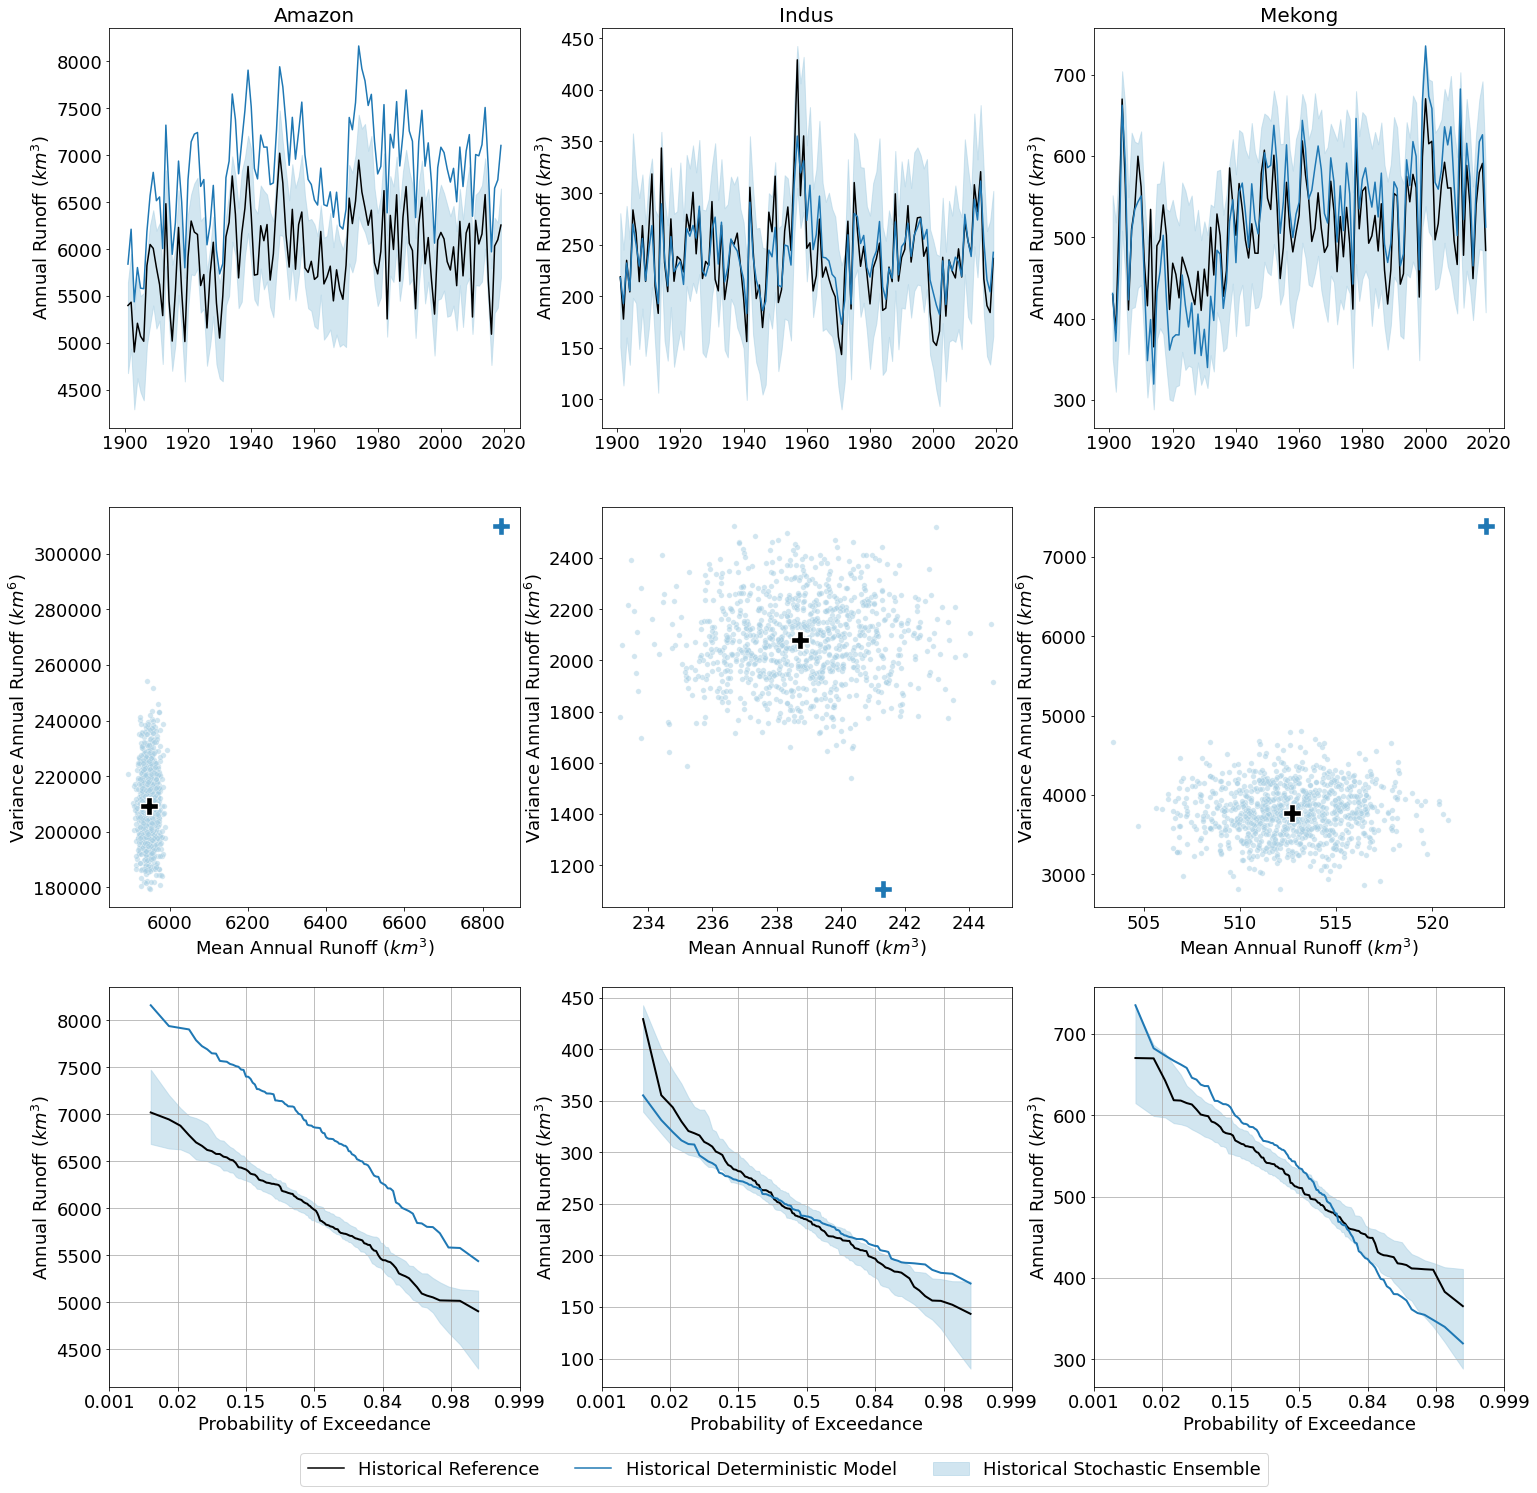

In [37]:
# results plots for a specific basin
fig,axes = plt.subplots(3,3,figsize=(25,25),
                                 gridspec_kw={'width_ratios': [1, 1,1]})
axes = axes.flatten()

bs_name_list = ['Amazon','Indus','Mekong']

#loop through basins
for i in range(len(bs_name_list)):
    bs_name = bs_name_list[i]
    bsid = data_annual[data_annual.basin_name==bs_name]['basin_id'].iloc[0] - 1
    df_basin = data_annual[data_annual.basin_name==bs_name] 
    df_basin_fut = fut_annual[fut_annual.basin_name==bs_name]

    boi_obs = q_ref[:,bsid] #observed
    boi_det = q_det[:,bsid] #deterministic
    boi_stoch = Q_hist[:,bsid,:] #stochastic
    boi_fdet = q_fut[:,bsid]#future
    boi_fstoch = Q_fut[:,bsid,:]#future stochastic

    # subplot 1: time series
    ax1 = axes[i]
    years = data_annual.year.unique()[:]
    fyears = fut_annual.year.unique()[:]
    sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
    sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
    ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5)
    ax1.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.set_title(bs_name,fontsize=20)

    #second row is for scatterplots
    ax2 = axes[i+3]
    sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                    label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
    sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False
                   ,marker='P')
    sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',
                    color=cpal[1],legend=False,marker='P')
    ax2.set_xlabel('Mean Annual Runoff ($km^3$)',fontsize=18)
    ax2.set_ylabel('Variance Annual Runoff ($km^6$)',fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    
    #third row is for FDCs
    # subplot 3: probability of exceedance for future
    ax3 = axes[i+6]
    
    ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],cpal[0],'hist_stoch',ax3)
    ax3.set_xlabel('Probability of Exceedance',fontsize=18)
    ax3.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)
    ax3.set_title('')
    ax3.tick_params(axis='both', which='major', labelsize=18)

fig.legend(['Historical Reference','Historical Deterministic Model','Historical Stochastic Ensemble'],
           ncol=3,loc='lower center',fontsize=18,
          bbox_to_anchor=(0.5, 0.065))
plt.show()

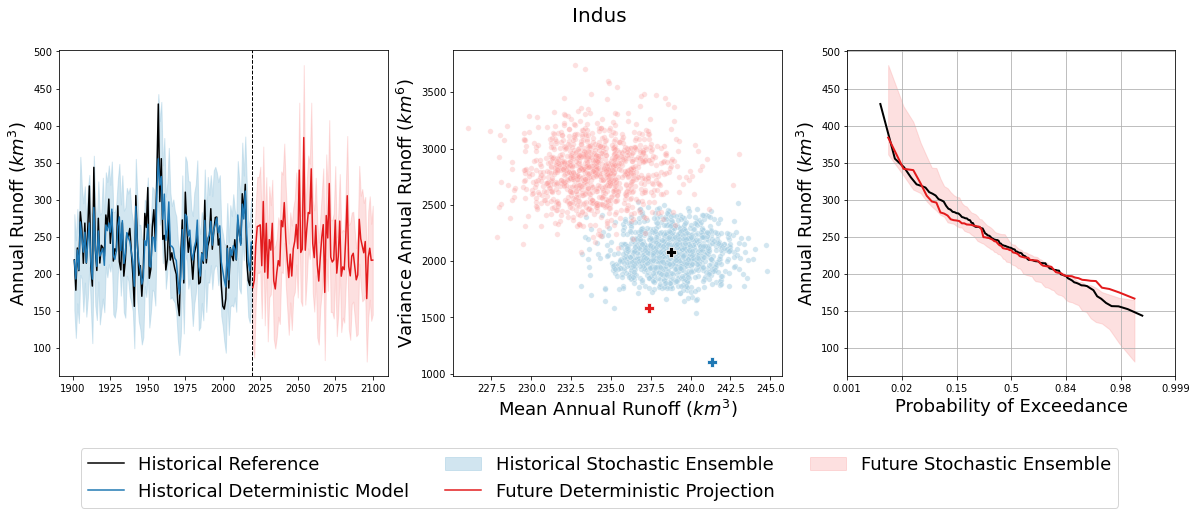

In [42]:
# results plots for a specific basin
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6),
                                 gridspec_kw={'width_ratios': [1, 1,1]})

bs_name = 'Indus'
bsid = data_annual[data_annual.basin_name==bs_name]['basin_id'].iloc[0] - 1

boi_obs = q_ref[:,bsid] #observed
boi_det = q_det[:,bsid] #deterministic
boi_stoch = Q_hist[:,bsid,:] #stochastic
boi_fdet = q_fut[:,bsid]#future
boi_fstoch = Q_fut[:,bsid,:]#future stochastic
df_basin = data_annual[data_annual.basin_name==bs_name] 
df_basin_fut = fut_annual[fut_annual.basin_name==bs_name]

# subplot 1: time series
years = data_annual.year.unique()[:]
fyears = fut_annual.year.unique()[:]
sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5)
sns.lineplot(ax=ax1,x=fyears,y=boi_fdet,label='Future Deterministic Projection',color=cpal[5],legend=False)
ax1.fill_between(fyears,np.min(boi_fstoch,axis=1),np.max(boi_fstoch,axis=1),color=cpal[4],alpha=0.3)
ax1.axvline(years[-1]+0.5,color='k',lw=1,ls='--')
ax1.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)

# subplot 2: plot scatterplots of mean vs variance in annual runoff
sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
sns.scatterplot(ax=ax2,x=np.mean(boi_fstoch,axis=0),y = np.var(boi_fstoch,axis=0),s=30,
                label='Future Stochastic Ensemble',color=cpal[4],legend=False,alpha=0.3)
sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=100,label='Observed',color='k',legend=False
               ,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=100,label='Historical Deterministic Model',
                color=cpal[1],legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_fdet)],y=[np.var(boi_fdet)],s=100,label='Future Deterministic Projection',
                color=cpal[5],legend=False,marker='P')
ax2.set_xlabel('Mean Annual Runoff ($km^3$)',fontsize=18)
ax2.set_ylabel('Variance Annual Runoff ($km^6$)',fontsize=18)

# subplot 3: probability of exceedance for future
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[5],cpal[0],'fut_stoch',ax3)
ax3.set_xlabel('Probability of Exceedance',fontsize=18)
ax3.set_ylabel('Annual Runoff ($km^3$)',fontsize=18)
ax3.set_title('')


fig.legend(['Historical Reference','Historical Deterministic Model','Historical Stochastic Ensemble',
            'Future Deterministic Projection','Future Stochastic Ensemble'],ncol=3,loc='lower center',
           fontsize=18,
          bbox_to_anchor=(0.5, -0.2))


#fig.text(0.05,0.5,bs_name,fontsize=24,rotation=90)

plt.suptitle(bs_name,fontsize=20)
plt.show()